In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import json
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from itertools import chain
def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

def get_best_downstream_loss(tb_dir):
    ea = event_accumulator.EventAccumulator(tb_dir)
    ea.Reload()
    try:  
        loss = ea.Scalars('best_downstream_loss__gen_9')[-1].value
        return loss
    except:
        return None
    
def get_data(exp, results):
    chromos = []
    for i, (fitness, chromo) in enumerate(zip(results["pop_vals"], results["chromos"])):
        c = list(chain.from_iterable(chromo[1]))
        c+=[i, exp, fitness[1]]
        chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns+=["exp_i", "exp", "fitness"]
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    exps = []
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-1] = c[-1]
            chromos_long[i][-2] = i
        exps.append(exp)
    columns_long = list(ops) + ["exp_i", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    df_long['exp'] = exps
    return df, df_long, ops

exps =[f"exp6_{i}" for i in range(4)]+ [f"exp8_{i}" for i in range(4, 8)] + \
        [f"exp10_{i}" for i in range(4)] + [f"exp11_{i}" for i in range(4)]


p = Path('/home/noah/ESSL/cc_experiments/')
dirs = [str(p_i) for p_i in list(p.glob('**'))]
# print(glob.glob(f'/home/noah/ESSL/cc_experiments/*/*/', recursive = True))
csv_map = []
for e in exps: 
    e_dirs = [p_i for p_i in dirs if e == p_i.split("/")[-1]]
    csv_map_i = []
    for e_dir in e_dirs:
        model_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/models"))])
        plot_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/plots"))])
        tbs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/tensorboard"))])
        
        finished_exps = model_dirs.intersection(plot_dirs)
        finished_exps_tbs = finished_exps.intersection(tbs)
        if len(finished_exps) != len(finished_exps_tbs):
            continue
        for f_e in finished_exps:
            csv_map_i.append([e, os.path.basename(f_e), e_dir, f_e])
        
    csv_map+=sorted(csv_map_i, key=lambda x: str(x[1]))
    
columns = ["exp", "seed", "exp_dir", "seed_dir"]
df = pd.DataFrame(csv_map, columns=columns)
df = df.drop_duplicates(["exp", "seed"],keep= 'last')
chromos_df = []
pop_vals_df = []
display(df["exp"].unique())
for exp in df["exp"].unique():
    exp_df = df[df["exp"] == exp]
    pop_vals = []
    for _, row in exp_df.iterrows():
        outcomes_dir = os.path.join(row["seed_dir"], "outcomes.json")
        algo = get_algorithm(os.path.join(row["seed_dir"], "params.txt"))
        try:
            tb = glob.glob(os.path.join(row["seed_dir"], "tensorboard/*/*.tfevents*" ))[0]
            best_loss = get_best_downstream_loss(tb)
        except:
            best_loss = None
        with open(outcomes_dir, "r") as f:
            outcomes = json.load(f)
            pop_vals+=[[exp, algo, row["seed"], c_val[0], c_val[1], best_loss, i] for i, c_val in enumerate(outcomes["pop_vals"])]
            cdf,_, ops = get_data(exp, outcomes)
            chromos_df.append(cdf)
    pop_vals_df+=pop_vals
df = pd.DataFrame(pop_vals_df, columns = ["exp", "algo", "seed", "generation", "fitness", "best_loss", "exp_i"])
# display(df)
# chromo_df = pd.DataFrame(chromos_df, columns=['exp', 'exp_i', 'chromo'])
chromo_df = pd.concat(chromos_df)
chromo_df

# df.merge(chromo_df, on=["exp", "exp_i"])
chromo_df[["exp", "exp_i"]]
display(df[["exp", "exp_i"]].dtypes)
display(chromo_df[["exp", "exp_i"]].dtypes)
df.index = df["exp_i"].astype('str') + "_" + df["exp"]
chromo_df.index = chromo_df["exp_i"].astype('str') + "_" + chromo_df["exp"]
df


/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


array(['exp6_0', 'exp6_1', 'exp6_2', 'exp6_3', 'exp8_4', 'exp8_5',
       'exp8_6', 'exp8_7', 'exp10_0', 'exp10_1', 'exp10_2', 'exp10_3',
       'exp11_0', 'exp11_1', 'exp11_2', 'exp11_3'], dtype=object)

exp      object
exp_i     int64
dtype: object

exp      object
exp_i     int64
dtype: object

,exp,algo,seed,generation,fitness,best_loss,exp_i
0_exp6_0,exp6_0,NNCLR,0,0,83.070000,0.513013,0
1_exp6_0,exp6_0,NNCLR,0,0,82.070000,0.513013,1
2_exp6_0,exp6_0,NNCLR,0,0,82.370000,0.513013,2
3_exp6_0,exp6_0,NNCLR,0,0,83.210000,0.513013,3
4_exp6_0,exp6_0,NNCLR,0,0,83.230000,0.513013,4
5_exp6_0,exp6_0,NNCLR,0,0,82.860000,0.513013,5
6_exp6_0,exp6_0,NNCLR,0,0,83.370000,0.513013,6
7_exp6_0,exp6_0,NNCLR,0,0,82.820000,0.513013,7
8_exp6_0,exp6_0,NNCLR,0,0,83.010000,0.513013,8
9_exp6_0,exp6_0,NNCLR,0,0,81.870000,0.513013,9


See how many seeds exist for each experiment

In [2]:
seed_df = df.groupby('exp')['seed'].unique().reset_index()
seed_df['exp'] = seed_df['exp'].apply(lambda x: x.split("_")[0])
seed_df['len exps'] = seed_df['seed'].apply(lambda x: len(x))
exps = {}
for exp, exp_df in seed_df.groupby('exp'):
    exps[exp] = exp_df.sort_values(by="len exps", ascending=True).iloc[0]["seed"]
exps
indexes = []
for i, row in df.iterrows():
    # print(exps[row['exp'].split("_")[0]])
    if row['seed'] not in exps[row['exp'].split("_")[0]]:
        indexes.append(i)

df = df.drop(index=indexes)


Visualize all seeds: We see not overly intereesting results when looking at all seeds.

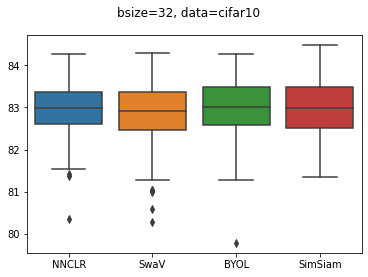

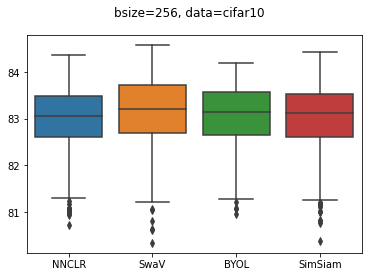

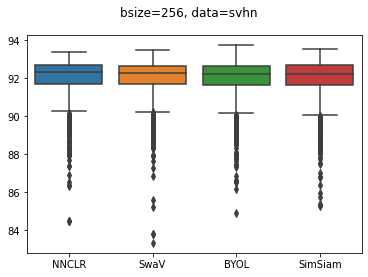

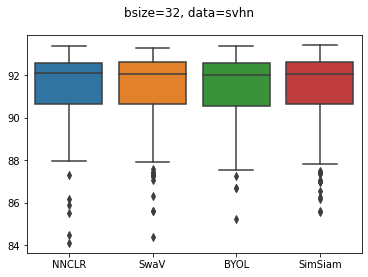

<Figure size 432x288 with 0 Axes>

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']
# sort based on algos
algos = {algo:ind for ind, algo in enumerate(df["algo"].unique())}
for e, title in zip(exps, exp_titles):
    df_e = df[df["exp"].str.contains(e)]
    x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
    sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
    plt.suptitle(title)
    plt.show()
    plt.clf()

Compare best seeds with manually selected best seeds:

In [3]:
max_seeds = df.groupby(["exp", "algo"])["seed", "fitness"].max()
manually_selected = glob.glob("/home/noah/ESSL/final_exps/optimization/*exp*/*")
manually_selected = [[m.split("/")[-2], m.split("/")[-1]] for m in manually_selected]
manually_selected = pd.DataFrame(manually_selected, columns = ["exp", "manually selected seed"])
merged = pd.merge(max_seeds, manually_selected, on=["exp"])
merged["selected optimal?"] = merged["seed"] == merged["manually selected seed"]
print(f"percent of manual seeds conatining best solution: {merged['selected optimal?'].sum() / len(merged)}")

percent of manual seeds conatining best solution: 0.4


In [4]:
# sns.set_theme()
# for group, data in df.groupby(["exp", "algo"]):
#     fig, ax = plt.subplots(1,2, figsize=(15, 5))
#     sns.boxplot(data=data, x="generation", y="fitness", color='white', ax=ax[0])
#     plt.suptitle(f"{group[0]} {group[1]}")
#     ax[0].set_ylabel("Test Accuracy")
#     for i, row in data.iterrows():
#         ax[0].scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#     avg_i = data.groupby("generation")['fitness'].median()
#     max_i = data.groupby("generation")['fitness'].max()
#     min_i = data.groupby("generation")['fitness'].min()
#     ax[1].plot(range(len(avg_i)), avg_i, 'b-')
#     ax[1].plot(range(len(max_i)), max_i, 'b-')
#     ax[1].plot(range(len(min_i)), min_i, 'b-')
#     ax[1].fill_between(range(len(avg_i)), min_i, max_i, color='b',
#                      alpha=0.2)
#     ax[1].set_xlabel("Generation")
#     ax[1].set_ylabel("Test Accuracy")
#     ax[1].set_xticks = (range(len(outcomes['avg'])))
#     plt.show()
#     plt.clf()

In [6]:
### sns.set_theme()

## max avg line plots for all four methods
# df_exp_generalized = df.copy()
# convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
#                   ["bs=32, cifar10", "bs=256, cifar10",
#                   "bs=256, svhn", "bs=32, svhn"])}
# df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
# algos = df_exp_generalized['algo'].unique()
# colors = sns.color_palette(n_colors=len(algos))
# colors = {algo:c for algo, c in zip(algos, colors)}
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, exp_data in data.groupby(["algo"]):
        
#         avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
#         max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
#         sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
#         sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo])
#         plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
#                                  alpha=0.2)
#     plt.legend()
#     plt.suptitle(convert[exp])
#     plt.show()
#     plt.clf()

visualize the best generation between all seeds

In [7]:
### sns.set_theme()

# ## max avg line plots for all four methods
# df_exp_generalized = df.copy()
# convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
#                   ["bs=32, cifar10", "bs=256, cifar10",
#                   "bs=256, svhn", "bs=32, svhn"])}
# df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
# algos = df_exp_generalized['algo'].unique()
# colors = sns.color_palette(n_colors=len(algos))
# colors = {algo:c for algo, c in zip(algos, colors)}
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, data_algo in data.groupby(["algo"]):
#         optimal_df = []
#         for gen, data_gen  in data_algo.groupby(["generation"]):
#             best_seed = data_gen.sort_values(by="fitness", ascending=False).iloc[0]["seed"]
#             data_gen = data_gen[data_gen["seed"] == best_seed]
#             optimal_df.append(data_gen)
#         optimal_df = pd.concat(optimal_df)
#         sns.boxplot(data=optimal_df, x="generation", y="fitness", color='white')
#         # plt.suptitle(f"{group[0]} {group[1]}")
#         plt.gca().set_ylabel("Test Accuracy")
#         for i, row in optimal_df.iterrows():
#             plt.scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#         plt.suptitle(f"Best Generation over all seeds: {algo}, {convert[exp]} (max test acc)")
#         plt.show()
#         plt.clf()
        
        
        
        

In [8]:
# for exp, data in df_exp_generalized.groupby(["exp"]):
#     for algo, data_algo in data.groupby(["algo"]):
#         optimal_df = []
#         for gen, data_gen  in data_algo.groupby(["generation"]):
#             best_seed = data_gen.groupby(["generation", "seed"])['fitness'].mean().reset_index().max()['seed']
#             data_gen = data_gen[data_gen["seed"] == best_seed]
#             optimal_df.append(data_gen)
#         optimal_df = pd.concat(optimal_df)
#         sns.boxplot(data=optimal_df, x="generation", y="fitness", color='white')
#         plt.gca().set_ylabel("Test Accuracy")
#         for i, row in optimal_df.iterrows():
#             plt.scatter(np.random.normal(row["generation"], 0.04), row["fitness"], alpha=0.7, color='skyblue')
#         plt.suptitle(f"Best Generation over all seeds: {algo}, {convert[exp]} (avg test acc)")
#         plt.show()
#         plt.clf()

###### Compare final generation of all seeds for each method: we see here that most of them are around the same

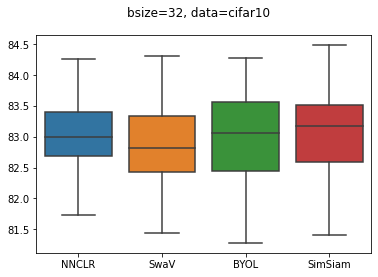

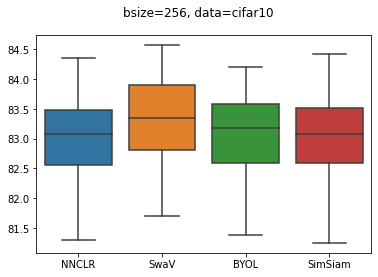

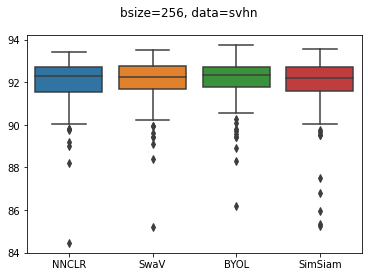

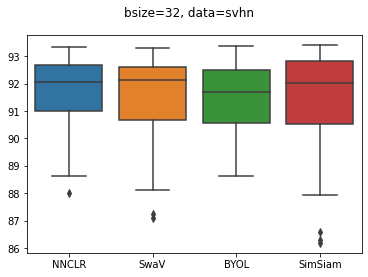

<Figure size 432x288 with 0 Axes>

In [9]:
df_final = df[df["generation"] == 9]
exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']


exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']
# sort based on algos
algos = {algo:ind for ind, algo in enumerate(df["algo"].unique())}
for e, title in zip(exps, exp_titles):
    df_e = df_final[df_final["exp"].str.contains(e)]
    x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
    sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
    plt.suptitle(title)
    plt.show()
    plt.clf()

# Plot the best fitness in final generation for each algorithm: this shows more interesting results!!

with bs 256, Sim Siam is overall best, but SwAV is best for 

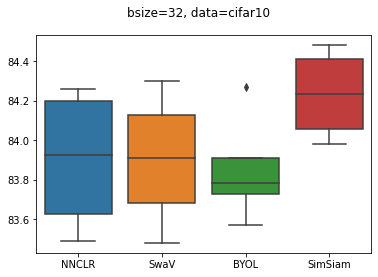

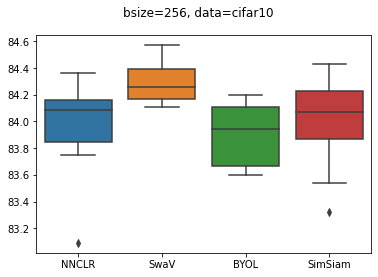

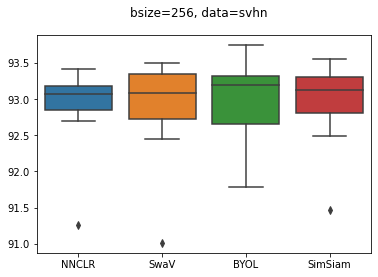

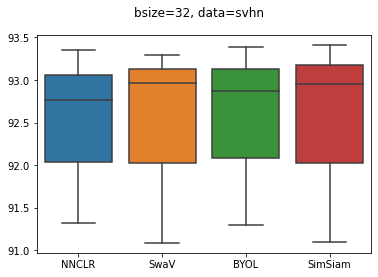

<Figure size 432x288 with 0 Axes>

In [10]:
colors = sns.color_palette(n_colors=len(algos))
colors = {algo:c for algo, c in zip(algos, colors)}
df_final_best = df_final.groupby(["exp", "seed", "algo"])["fitness"].max().reset_index(name='fitness').dropna()

exps = ['exp6', 'exp8', 'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']
inds = {a:i for a, i in zip(df['algo'].unique(), range(len(df['algo'].unique())))}
for e, title in zip(exps, exp_titles):
    df_e = df_final_best[df_final_best["exp"].str.contains(e)]
    x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
    sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y], 
                # color='white'
               )
#     for x, y in x_y:
#         plt.scatter(np.random.normal(inds[x], 0.04), y, alpha=0.7, color=colors[x])
    plt.suptitle(title)
    plt.show()
    plt.clf()

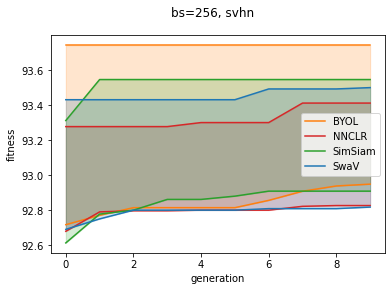

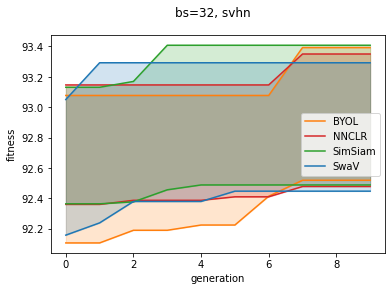

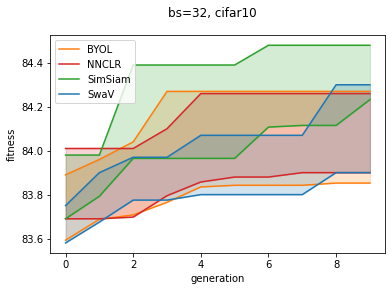

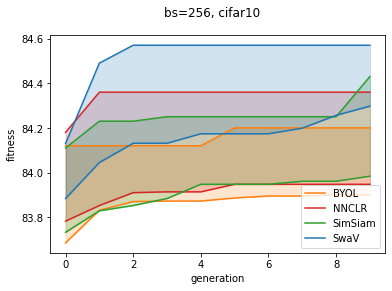

<Figure size 432x288 with 0 Axes>

In [29]:

df_total_best = df.groupby(["exp", "seed", "algo", "generation"])["fitness"].max().reset_index(name='fitness').dropna()
df_exp_generalized = df_total_best.copy()
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}
df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
algos = df_exp_generalized['algo'].unique()
colors = sns.color_palette(n_colors=len(algos))
colors = {algo:c for algo, c in zip(algos, colors)}
for exp, data in df_exp_generalized.groupby(["exp"]):
    for algo, exp_data in data.groupby(["algo"]):
        
        avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
        max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
        sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
        sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo])
        plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
                                 alpha=0.2)
    plt.legend()
    plt.suptitle(convert[exp])
    plt.show()
    plt.clf()

Compare the generation with the best test acc for each method

In [11]:
# df_best_gen = df.groupby(["exp", "algo"]).max().reset_index()

# exps = ['exp6', 'exp8', 'exp10', 'exp11']
# exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#              'bsize=256, data=svhn', 'bsize=32, data=svhn']

# for e, title in zip(exps, exp_titles):
#     df_e = df[df["exp"].str.contains(e)]
#     df_best_gen_e = df_best_gen[df_best_gen["exp"].str.contains(e)][["exp", "algo", "seed", "generation"]]
#     bool_df = ((df_e == df_best_gen_e.iloc[0]).sum(axis=1) == 4).astype(int)
#     for _, row in df_best_gen_e.iterrows():
#         bool_df += ((df_e == row).sum(axis=1) == 4).astype(int)
#     bool_df = bool_df.astype(bool)
#     df_e = df_e[bool_df]
#     x_y = sorted(list(zip(df_e["algo"], df_e["fitness"])), key=lambda x: algos[x[0]])
#     sns.boxplot(x=[x[0] for x in x_y], y=[x[1] for x in x_y])
#     plt.suptitle(title)
#     plt.show()
#     plt.clf()

In [12]:
# from IPython.core.display import display, HTML
# enc= {k:v for k, v in zip(['exp6', 'exp8', 'exp10', 'exp11'], 
#                           ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
#                              'bsize=256, data=svhn', 'bsize=32, data=svhn'])}

# rev_enc = {v:k for k,v in enc.items()}

# df_table = df_best_gen[['exp', 'algo','fitness', 'best_loss']]
# df_table.columns = ['exp', 'algo', 'test acc', 'test loss']
# df_table['exp'] = df_table['exp'].apply(lambda x: enc[x.split('_')[0]])
# for exp in df_table["exp"].unique():
#     display(HTML(df_table[df_table["exp"]== exp].to_html()))
# # latex
# for exp in df_table["exp"].unique():
#     print(df_table[df_table["exp"]== exp].drop(columns=["exp"]).to_latex(caption=f"best test acc, {exp}", label="bta_"+rev_enc[exp]))
# df_table.to_csv("/home/noah/ESSL/cc_experiments/results/best_results_so.csv")
# best_vals = []
# for e in df_table["exp"].unique():
#     best_vals.append(df_table[df_table['exp'] == e].sort_values(by='test acc', ascending=False).iloc[0])
# df_table = pd.DataFrame(best_vals)

# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_best.csv")
# # df["algo"].value_counts()
# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_best.csv")

In [13]:
# df_best_gen_seed = df.groupby(["exp", "algo", "seed"]).max().reset_index()
# df_best_gen_seed = df_best_gen_seed.groupby(["exp", "algo"]).mean().reset_index()

# df_table = df_best_gen_seed[['exp', 'algo','fitness', 'best_loss']]
# df_table.columns = ['exp', 'algo', 'avg test acc', 'avg test loss']
# df_table['exp'] = df_table['exp'].apply(lambda x: enc[x.split('_')[0]])
# for exp in df_table["exp"].unique():
#     display(HTML(df_table[df_table["exp"]== exp].to_html()))

# # latex
# rev_enc = {v:k for k,v in enc.items()}
# for exp in df_table["exp"].unique():
#     print(df_table[df_table["exp"]== exp].drop(columns=["exp"]).to_latex(caption=f"avg best test acc, {exp}", label="abta_"+rev_enc[exp]))    
# # df_table.to_csv("/home/noah/ESSL/cc_experiments/results/so_avg_best.csv")

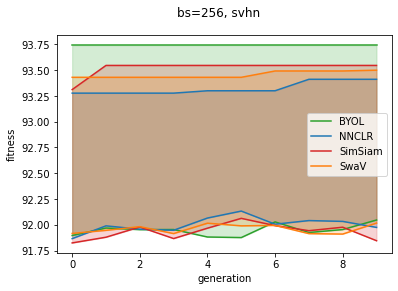

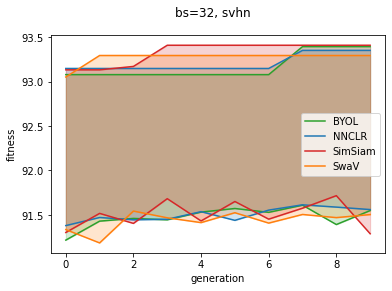

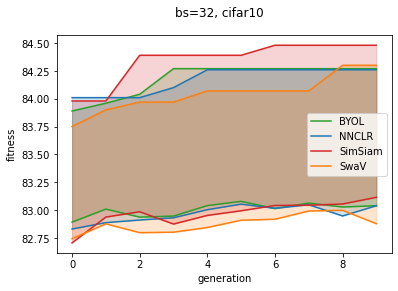

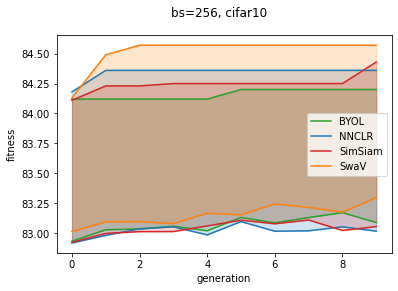

<Figure size 432x288 with 0 Axes>

In [14]:
### sns.set_theme()

## max avg line plots for all four methods
df_exp_generalized = df.copy()
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}
df_exp_generalized['exp'] = df_exp_generalized['exp'].apply(lambda x: x.split("_")[0])
algos = df_exp_generalized['algo'].unique()
for exp, data in df_exp_generalized.groupby(["exp"]):
    for algo, exp_data in data.groupby(["algo"]):
        
        avg_e = exp_data.groupby("generation")["fitness"].mean().reset_index()
        max_e = exp_data.groupby("generation")["fitness"].max().reset_index()
        sns.lineplot(data=avg_e, x="generation", y="fitness", color=colors[algo], label=algo)
        sns.lineplot(data=max_e, x="generation", y="fitness", color=colors[algo])
        plt.fill_between(avg_e["generation"], avg_e["fitness"], max_e["fitness"], color=colors[algo],
                                 alpha=0.2)
    plt.legend()
    plt.suptitle(convert[exp])
    plt.show()
    plt.clf()

In [15]:
df

,exp,algo,seed,generation,fitness,best_loss,exp_i
0,exp6_0,NNCLR,0,0,83.070000,0.513013,0
1,exp6_0,NNCLR,0,0,82.070000,0.513013,1
2,exp6_0,NNCLR,0,0,82.370000,0.513013,2
3,exp6_0,NNCLR,0,0,83.210000,0.513013,3
4,exp6_0,NNCLR,0,0,83.230000,0.513013,4
...,...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991,145
14996,exp11_3,NNCLR,2,9,92.685925,0.302991,146
14997,exp11_3,NNCLR,2,9,92.685925,0.302991,147
14998,exp11_3,NNCLR,2,9,93.350492,0.302991,148


Operator Importance

In [16]:
def operator_importance(df, ops, N=50):
    exp = df['exp'].iloc[0]
    df = df.drop(columns=["op1", "op2", "op3", "exp_i", "exp"])
    df.columns= ["op1", "op2", "op3", "test acc"]
    df = df.sort_values(by="test acc")
    counts = []
    both = []
    for op in ops:
        c = (df["op1"] == op)[:N].sum() + (df["op2"] == op)[:N].sum() + (df["op3"] == op)[:N].sum()
        counts.append(c)
        both.append([op, c])
    a = [x[1] for x in both]
    both.sort(key=lambda x: x[1], reverse=True)
    both = [[i[0], (float(i[1])-min(a))/(max(a)-min(a))] for i in both]
    palette = [PALETTE[op] for op, _ in both]

    sns.barplot(x=[i[1] for i in both], y=[i[0] for i in both], palette=palette)
    plt.suptitle(f"op importance, {exp}")
    plt.show()
    plt.clf()
    
def gen_palette(full_df):
    ops = set(list(full_df["aug1"].unique()) + list(full_df["aug2"].unique()) + list(full_df["aug3"].unique()))
    palette = {op:c for op, c in zip(ops, sns.color_palette("hls", len(ops)))}
    return palette
PALETTE = gen_palette(chromo_df)


In [17]:
df_final = df[df["generation"] == 9]
# display(df_final)
df_final_best = df_final.groupby(["exp", "seed", "algo"])["fitness"].max()#.reset_index(name='fitness').dropna()
display(df_final_best)
exps = ['exp6', 'exp8', 
        'exp10', 'exp11']
exp_titles = ['bsize=32, data=cifar10', 'bsize=256, data=cifar10', 
             'bsize=256, data=svhn', 'bsize=32, data=svhn']


inds = {a:i for a, i in zip(df['algo'].unique(), range(len(df['algo'].unique())))}
for e, title in zip(exps, exp_titles):
    print(e)
    df_e = df_final_best[df_final_best["exp"].str.contains(e)]
    import pdb;pdb.set_trace()
    keys = df.iloc[df_e.index][['exp', 'exp_i']]
    bool_i = chromo_df[["exp", "exp_i"]].isin(keys).all(axis=1)
    best_df = chromo_df[bool_i]
    print(e)
    print(best_df['exp'].unique())
    ops = set(list(best_df["aug1"].unique())+list(best_df["aug2"].unique())+list(best_df["aug3"].unique()))
    operator_importance(best_df, ops, N=50)
best_df

exp      seed  algo 
exp10_0  0     SwaV     91.011063
         1     SwaV     93.004763
         2     SwaV     93.362016
         5     SwaV     93.500307
         6     SwaV     93.077750
                          ...    
exp8_7   3     NNCLR    83.750000
         4     NNCLR    84.180000
         5     NNCLR    83.090000
         6     NNCLR    84.360000
         7     NNCLR    84.150000
Name: fitness, Length: 88, dtype: float64

exp6


KeyError: 'exp'